<a href="https://colab.research.google.com/github/abhionair1/Autoencoder/blob/main/Redone_U3W12_Demo_CNN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This notebook aims at discovering Convolutional Neural Network. We will see the theory behind it, and an implementation in Pytorch on FashionMNIST dataset.


In [1]:
!pip3 install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=c66b67de591ab85ed980a48e44fabb82cc92399b8a8c299212e14917e3ba892a
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision import datasets, transforms, models

from torchviz import make_dot

import numpy as np

import os
os.environ["PATH"] += os.pathsep + r"libraries/graphviz-2.38/release/bin"

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes

![FashionMNIST Dataset](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)

Pytorch's torchvision module conveniently packages the FashionMNIST dataset into a `torchvision.datasets.FashionMNIST` class for us. We simply need to specify the dataset split (train/test) and the transformations and augmentations we want to apply on each image. We wrap the dataset objects via Pytorch's `torch.utils.data.DataLoader` class to get dataloaders which will return entire batches of samples, and also optionally shuffle the dataset internally.

In [3]:
'''
Training time transformations and problem specific data augmentations can be applied here.
'''
transforms_train = transforms.Compose([
    transforms.ToTensor(),
    # We've computed the mean and variance for this dataset beforehand, so we can plug it in here
    transforms.Normalize((0.1307,), (0.3081,))
])
'''
FashionMNIST is a subclass of torch.utils.data.Dataset, and have __getitem__ and __len__ methods implemented. For creating
custom datasets you will have to inherit Dataset class and override __len__() and __getitem__()
'''
dataset_train = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transforms_train
)
'''
Pass dataset object to DataLoader, which will later be used for iterating over minibatches
'''
dataloader_train = DataLoader(
    dataset_train, batch_size=128, shuffle=True,
)

'''
Repeat the same thing (defining transforms => dataset instantiation => dataloader creationg) for the test set
'''
transforms_test =transforms.Compose([
    transforms.ToTensor(),
    # We've computed the mean and variance for this dataset beforehand, so we can plug it in here
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset_test = datasets.FashionMNIST(
    root='./data', train=False, download=False, transform=transforms_test
)

dataloader_test = DataLoader(
    dataset_test, batch_size=128, shuffle=False,
)

100%|██████████| 26421880/26421880 [00:03<00:00, 6776158.58it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268571.66it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4967278.77it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7684084.34it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



We now create a CNN class, which has to be a subclass of `torch.nn.Module` and have its own `__init__` and `forward` functions.

We choose a simple architecture with `3 convolutional blocks` followed by `2 fully connected blocks`.

For layers that do not have any parameters, i.e. layers that are simple mathematical operations on the input, such as ReLU, sigmoid, tanh, softmax, dropout, etc., Pytorch provides a `torch.nn.functional` module with such layers.

While one can create a ReLU layer by using `nn.ReLU`, it's easier to just call `torch.nn.functional.relu` on a tensor. This helps reduce clutter, since large models can have many such layers.

NOTE: We import `torch.nn.functional` as the alias `F`.

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([128, 1, 28, 28]) torch.Size([128]) torch.Size([128, 10])


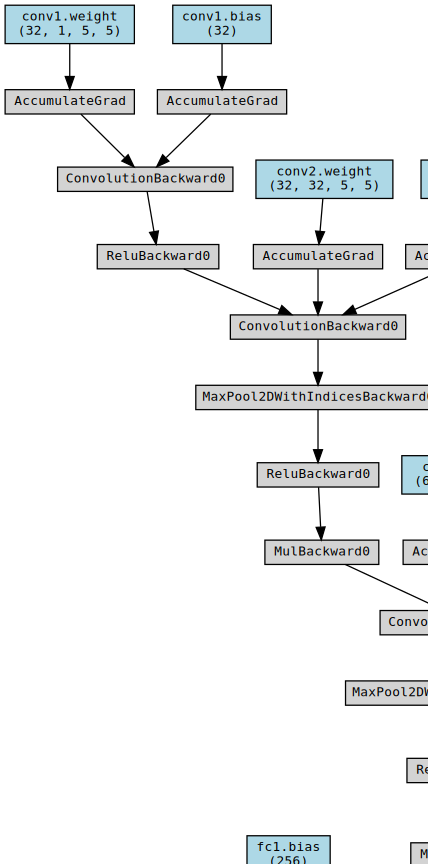

In [4]:
class CNN(nn.Module):
    def __init__(self):
        #super(CNN, self).__init__()
        super().__init__()
        # nn.Conv2d API : torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)  # 32 filters of 5x5 size and depth 1 (since input channel = 1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5) # 32 filters of 5x5 size and depth 32 (since input channel =  1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5) # 64 filters of 5x5 size and depth 32 #params = 64x5x5x32 + 64
        # nn.Linear API : torch.nn.Linear(in_features, out_features, bias=True)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # BLOCK 1: CONV + RELU
        x = F.relu(self.conv1(x))
        # BLOCK 2: CONV + MAXPOOL + RELU + DROPOUT
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        # BLOCK 3: CONV + MAXPOOL + RELU + DROPOUT
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        # FLATTEN
        x = x.flatten(start_dim=1)
        # BLOCK 4: FC + RELU + DROPOUT
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        # BLOCK 5: FC + LOG SOFTMAX
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

model = CNN()
print(model)

# get a random training batch
iterator = iter(dataloader_train)
X_batch, y_batch = next(iterator)
print(X_batch.shape, y_batch.shape, model(X_batch).shape)

# pass a batch through the model and visualize the architecture
# NOTE: we do not have to explicitly call model.forward(inputs), instead we just do model(inputs)
# This is because PyTorch internally takes care of, giving us this syntactic sugar
make_dot(model(X_batch), params=dict(model.named_parameters()))

Now we create some utility functions to help with the training and evaluation process. Most of this is boilerplate code that can be reused with simple changes.

For training, we iterate over the datalaoder to get batches, and for each batch we do the following:

- move each batch onto the specified device
- perform a forward pass through the model to get the outputs
- compute the loss based on the outputs and targets
- compute the gradients via backpropagation
- update the weights via the optimizer

Certain layers, e.g. dropout, operate differently in training versus inference modes. To account for the same, we do:

- model.train() to set all such layers to training mode
- model.eval() to set all such layers to inference mode

In [5]:
def train(model, device, data_loader, optimizer, criterion, epoch):
    model.train()
    loss_train = 0
    num_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
        prediction = output.argmax(dim=1)
        num_correct += prediction.eq(target).sum().item()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tAccuracy: {:.0f}%'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss_train / (batch_idx + 1),
                100. * num_correct / (len(data) * (batch_idx + 1))))
    loss_train /= len(data_loader)
    accuracy = num_correct / len(data_loader.dataset)
    return loss_train, accuracy


def test(model, device, data_loader, criterion):
    model.eval()
    loss_test = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            loss_test += loss.item()  # sum up batch loss
            prediction = output.argmax(dim=1)
            num_correct += prediction.eq(target).sum().item()
    loss_test /= len(data_loader)
    accuracy = num_correct / len(data_loader.dataset)
    return loss_test, accuracy

Now we put it all together:

- Create the model
- Set up the loss function (cross entropy)
- Add an optimizer (in this case, Adam)
- [Optional] Have a learning rate scheduler

In [6]:
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 5):
    loss_train, acc_train = train(model, device, dataloader_train, optimizer, criterion, epoch)
    print('Epoch {} Train: Loss: {:.4f}, Accuracy: {:.3f}%\n'.format(
        epoch, loss_train, 100. * acc_train))
    loss_test, acc_test = test(model, device, dataloader_test, criterion)
    print('Epoch {} Test : Loss: {:.4f}, Accuracy: {:.3f}%\n'.format(
        epoch, loss_test, 100. * acc_test))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.2946	Accuracy: 15%
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.4551	Accuracy: 46%
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.1442	Accuracy: 57%
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.9968	Accuracy: 63%
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.9103	Accuracy: 66%
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.8536	Accuracy: 68%
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.8072	Accuracy: 70%
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.7744	Accuracy: 71%
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.7449	Accuracy: 72%
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.7210	Accuracy: 73%
Epoch 1 Train: Loss: 0.7124, Accuracy: 73.315%

Epoch 1 Test : Loss: 0.4711, Accuracy: 82.600%

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.5184	Accuracy: 77%
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.5070	Accuracy: 82%
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.5081	Accuracy: 81%
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.5023	Accuracy: 81%
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.4948	